TODO
- GP with different prior

In [289]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

import matplotlib.pyplot as plt

Linear model with no variance

In [290]:
my_seed = np.random.default_rng(seed=591) # For replicability

def cub_fn(x):
    return x[..., 0]*(x[..., 0] - 1)*(x[..., 0]+1)

index_vals = np.expand_dims( # this makes the size of the sample (3,1)
    my_seed.uniform(low=-1., high=1., size=5),
    axis=-1 # last axis
    )

obs_vals = cub_fn(index_vals)

my_GP = tfd.GaussianProcess(
      kernel=tfk.ExponentiatedQuadratic(
          amplitude=tf.Variable(1., dtype=np.float64, name="amplitude"),
          length_scale=tf.Variable(1., dtype=np.float64, name="length_scale")
      ),
      index_points=index_vals)

print(my_GP.trainable_variables[1])

Adam_optim = tf.optimizers.Adam()


<tf.Variable 'length_scale:0' shape=() dtype=float64, numpy=1.0>


In [291]:
@tf.function()
def optimize():
  with tf.GradientTape() as tape:
    loss = -my_GP.log_prob(obs_vals)
  grads = tape.gradient(loss, my_GP.trainable_variables)
  Adam_optim.apply_gradients(zip(grads, my_GP.trainable_variables))
  return loss


num_iters = 7000

lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = optimize()
  lls_[i] = loss

amp_fin = my_GP.trainable_variables[0].numpy()
len_fin = my_GP.trainable_variables[1].numpy()

print('Trained parameters:')
print('amplitude: {}'.format(amp_fin))
print('length_scale: {}'.format(len_fin))


Trained parameters:
amplitude: 0.25353429007713696
length_scale: 0.5427608245129216


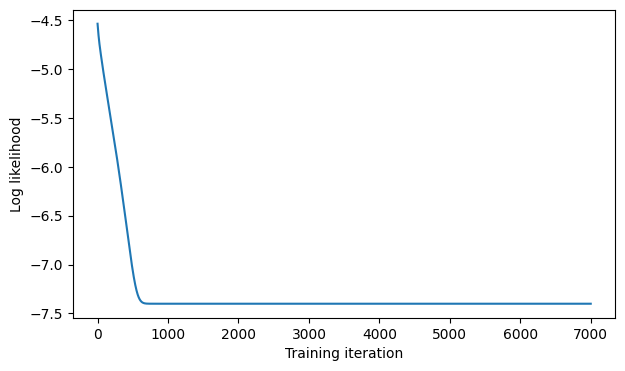

In [292]:
plt.figure(figsize=(7, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log likelihood")
plt.show()


In [293]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amp_fin, len_fin)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=index_vals,
    observations=obs_vals,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)


/tmp/ipykernel_2135/3001543521.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


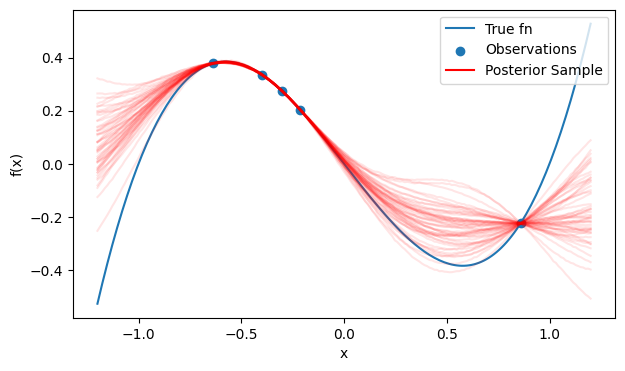

In [294]:
plt.figure(figsize=(7, 4))
plt.plot(predictive_index_points_, cub_fn(predictive_index_points_),
         label='True fn')
plt.scatter(index_vals[:, 0], obs_vals,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

Now we construct a GP for the same function with observation error

In [295]:
num_obs_err=20

my_seed_err=np.random.default_rng(seed=914)

def cub_fn_err(x):
    return x[..., 0]*(x[..., 0] - 1)*(x[..., 0]+1) + my_seed.normal(scale=.1, size=num_obs_err)

index_vals_err = np.expand_dims( # this makes the size of the sample (3,1)
    my_seed_err.uniform(low=-1., high=1., size=num_obs_err),
    axis=-1 # last axis
    )

obs_vals_err = cub_fn_err(index_vals_err)

my_GP_err = tfd.GaussianProcess(
      kernel=tfk.ExponentiatedQuadratic(
          amplitude=tf.Variable(1., dtype=np.float64, name="amplitude_err"),
          length_scale=tf.Variable(1., dtype=np.float64, name="length_scale_err")
      ),
      observation_noise_variance=tf.Variable(1., dtype=np.float64, name="observation_noise_variance_err"),
      index_points=index_vals_err)


print(my_GP_err.trainable_variables)

(<tf.Variable 'amplitude_err:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'length_scale_err:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'observation_noise_variance_err:0' shape=() dtype=float64, numpy=1.0>)


Trained parameters:
amplitude_err: 0.25353429007713696
length_scale_err: 0.5427608245129216
observation_noise_variance_err: 0.014781696799272675


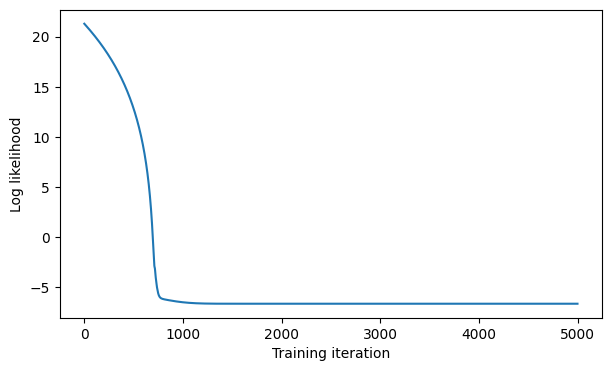

In [296]:
Adam_optim = tf.optimizers.Adam() # somehow need this again? maybe when you do the optimize function it stores info?

@tf.function()
def optimize_err():
  with tf.GradientTape() as tape:
    loss = -my_GP_err.log_prob(obs_vals_err)
  grads = tape.gradient(loss, my_GP_err.trainable_variables)
  Adam_optim.apply_gradients(zip(grads, my_GP_err.trainable_variables))
  return loss


num_iters_err = 5000

lls_err = np.zeros(num_iters_err, np.float64)
for i in range(num_iters_err):
  loss_err = optimize_err()
  lls_err[i] = loss_err

amp_fin_err = my_GP_err.trainable_variables[0].numpy()
len_fin_err = my_GP_err.trainable_variables[1].numpy()
obs_var_fin_err = my_GP_err.trainable_variables[2].numpy()

print('Trained parameters:')
print('amplitude_err: {}'.format(amp_fin))
print('length_scale_err: {}'.format(len_fin))
print('observation_noise_variance_err: {}'.format(obs_var_fin_err))

plt.figure(figsize=(7, 4))
plt.plot(lls_err)
plt.xlabel("Training iteration")
plt.ylabel("Log likelihood")
plt.show()

In [297]:
optimized_kernel_err = tfk.ExponentiatedQuadratic(amp_fin_err, len_fin_err)
gprm_err = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_err,
    index_points=predictive_index_points_,
    observation_index_points=index_vals_err,
    observations=obs_vals_err,
    observation_noise_variance=obs_var_fin_err,
    predictive_noise_variance=0.)

num_samples_err = 50
samples_err = gprm_err.sample(num_samples_err)

/tmp/ipykernel_2135/4068457692.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


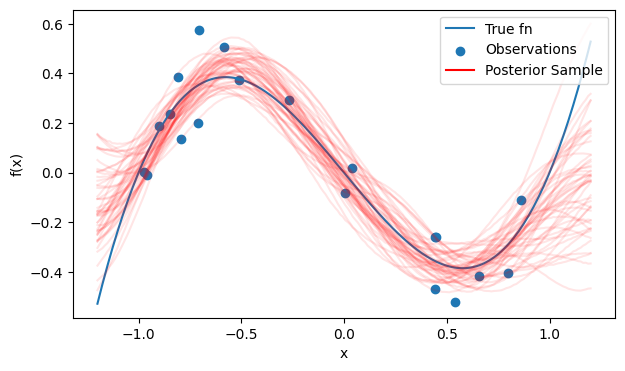

In [298]:
plt.figure(figsize=(7, 4))
plt.plot(predictive_index_points_, cub_fn(predictive_index_points_),
         label='True fn')
plt.scatter(index_vals_err[:, 0], obs_vals_err,
            label='Observations')
for i in range(num_samples_err):
  plt.plot(predictive_index_points_, samples_err[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()